# Process ICESat-2 data for Amery melt lakes paper
This script pulls the relevant data from the ATL03 and ATL06 granules and compiles them into a pickle file. 
The granules are not on github, and need to be downloaded from [NSIDC](https://nsidc.org/data/icesat-2/data-sets):
- ATL03_20190102184312_00810210_003_01.h5
- ATL06_20190102184312_00810210_003_01.h5

In [1]:
%matplotlib notebook
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
from readers.read_HDF5_ATL03 import read_HDF5_ATL03
from readers.read_ICESat2_ATL06 import read_HDF5_ATL06
from readers.get_ATL03_x_atc_corrected import get_ATL03_x_atc_corrected

## define filenames and latitude limits between which data is extracted for the 4 melt lakes

In [2]:
data_dir = 'data/ATL03h5v003/'
atl03file = 'ATL03_20190102184312_00810210_003_01.h5'
atl06file = 'ATL06_20190102184312_00810210_003_01.h5'
beam = 'gt2l'
ponds = ['pond1','pond2','pond3','pond4']

latlims = {"pond1": [-73.000, -72.987], 
           "pond2": [-72.899, -72.867], 
           "pond3": [-71.878, -71.866], 
           "pond4": [-71.650, -71.632]}

xlims_plot = {"pond1": [-72.9969, -72.9890], 
              "pond2": [-72.8937, -72.8757], 
              "pond3": [-71.8767, -71.8669], 
              "pond4": [-71.6481, -71.6376]}

ylims_plot = {"pond1": [217, 224], 
              "pond2": [204, 212], 
              "pond3": [89, 98], 
              "pond4": [76, 88]}

## read data from .h5 granules into dictionary format

In [3]:
%%time
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams = read_HDF5_ATL03(data_dir+atl03file)
get_ATL03_x_atc_corrected(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)
data03 = IS2_atl03_mds[beam]
IS2_atl06_mds, IS2_atl06_attrs, IS2_atl06_beams = read_HDF5_ATL06(data_dir+atl06file)
data06 = IS2_atl06_mds[beam]

CPU times: user 23.2 s, sys: 5.09 s, total: 28.3 s
Wall time: 28.9 s


## extract variables of interest

In [4]:
%%time
IS2_timestart = calendar.timegm(time.strptime('Jan 1, 2018 @ 00:00:00 UTC', '%b %d, %Y @ %H:%M:%S UTC'))
time_start = IS2_atl03_attrs['time_coverage_start']
beam_type = IS2_atl03_attrs[beam]['atlas_beam_type'].decode()
track = IS2_atl03_mds['orbit_info']['rgt'][0]
lat_gt = data06['land_ice_segments']['latitude']
lon_gt = data06['land_ice_segments']['longitude']
h_li = data06['land_ice_segments']['h_li']
lat = data03['heights']['lat_ph']
lon = data03['heights']['lon_ph']
x_atc = data03['heights']['x_atc']
x_atc += np.random.uniform(-0.35, 0.35, len(x_atc))  # data seems to be chunked up in about 70cm distances, so add noise
dt = data03['heights']['delta_time']
h = data03['heights']['h_ph']
conf = data03['heights']['signal_conf_ph']
landice = 3  # land ice is fourth column of confidence array
conf = conf[:, landice]
vals = [lat,lon,x_atc,dt,h,conf,lat_gt,lon_gt,h_li]
keys = ['atl03_lat','atl03_lon','atl03_xatc','atl03_dt','atl03_h','atl03_conf_li','atl06_lat','atl06_lon','atl06_h']

CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 82 ms


## put data into a dictionary to have all relevant data compiled together for each of the melt lakes

In [5]:
%%time
ponddata = {}
for p in ponds:
    inpond03 = (lat > latlims[p][0]) & (lat < latlims[p][1])
    inpond06 = (lat_gt > latlims[p][0]) & (lat_gt < latlims[p][1])
    
    mn_lat = latlims[p][0] - (latlims[p][1] - latlims[p][0])
    mx_lat = latlims[p][1] + (latlims[p][1] - latlims[p][0])
    inpond03 = (lat > mn_lat) & (lat < mx_lat)
    inpond06 = (lat_gt > mn_lat) & (lat_gt < mx_lat)
    
    ponddata[p] = {k:(v[inpond03] if 'atl03' in k else v[inpond06]) for (k,v) in zip(keys, vals)}
    ponddata[p]['track'] = track
    ponddata[p]['beam'] = beam
    ponddata[p]['beam_type'] = beam_type
    dtseconds = np.median(ponddata[p]['atl03_dt'])
    tp = time.gmtime((IS2_timestart + dtseconds))
    IS2time = '%04d-%02d-%02d %02d:%02d:%02d UTC' % (tp.tm_year, tp.tm_mon, tp.tm_mday, tp.tm_hour, tp.tm_min, tp.tm_sec)
    ponddata[p]['date_time'] = IS2time
    ponddata[p]['mean_lat'] = np.median(ponddata[p]['atl06_lat'])
    ponddata[p]['mean_lon'] = np.median(ponddata[p]['atl06_lon'])
    ponddata[p]['latlims'] = latlims[p]
    ponddata[p]['xlims_plot'] = xlims_plot[p]
    ponddata[p]['ylims_plot'] = ylims_plot[p]
    ponddata[p]['granule'] = atl03file

CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 246 ms


## make plots to check that it worked

<IPython.core.display.Javascript object>


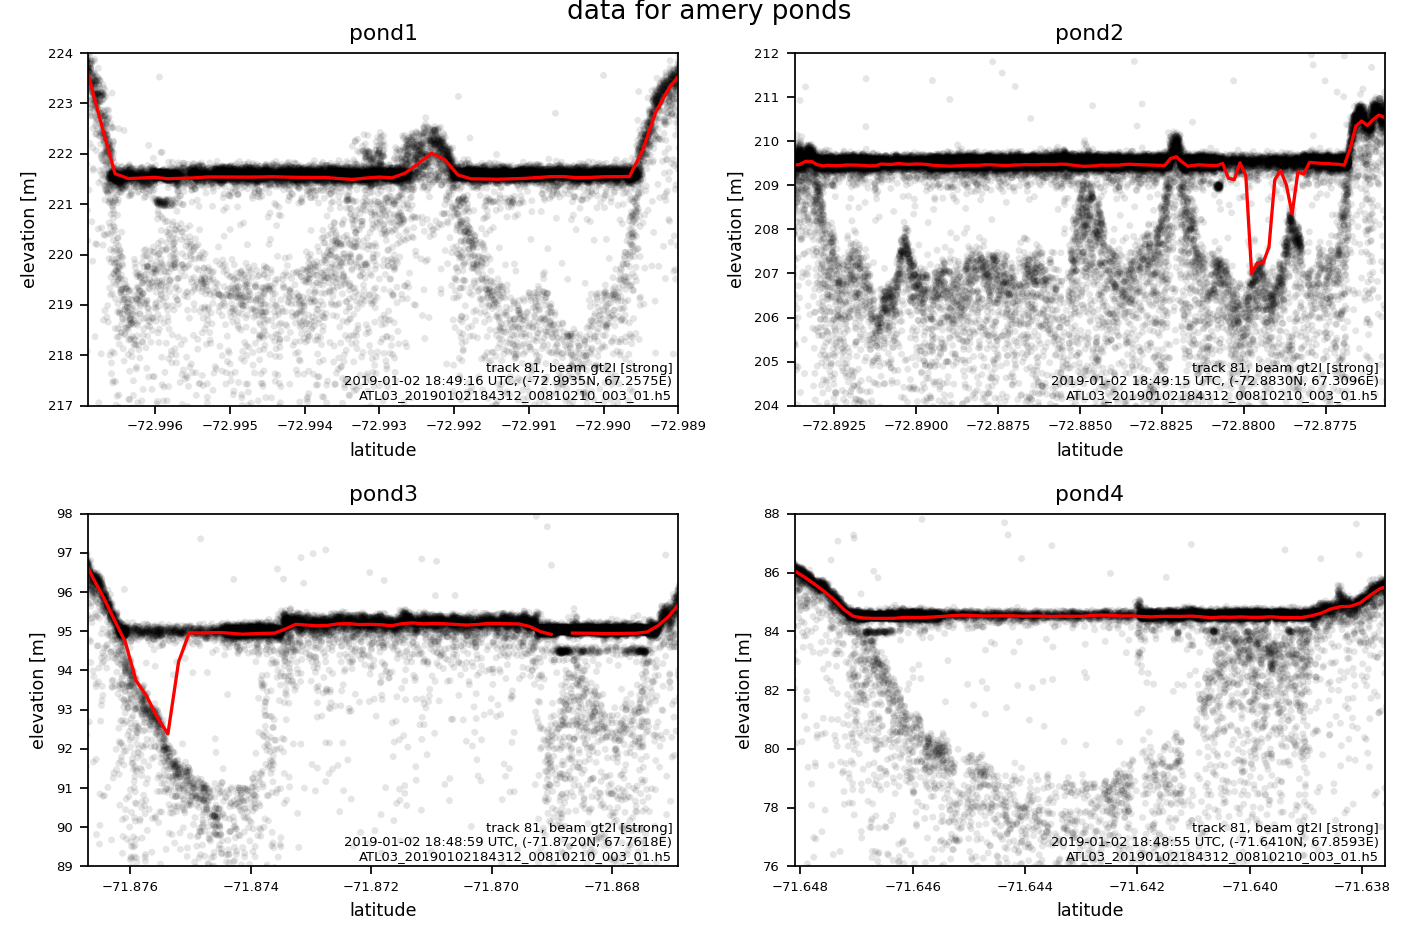

In [6]:
fig = plt.figure(figsize=[9, 6])
for i,pond in enumerate(ponddata):
    ax = fig.add_subplot(2,2,i+1)
    p = ponddata[pond]
    ax.scatter(p['atl03_lat'],p['atl03_h'],s=10,c='k',alpha=0.1,edgecolors='none')
    elev = p['atl06_h']
    elev[elev>1e10] = np.nan
    ax.plot(p['atl06_lat'],elev,'r-')
    desc = 'track %s, beam %s [%s]\n%s, (%.4fN, %.4fE)\n%s' % (p['track'],
                                                p['beam'],
                                                p['beam_type'],
                                                p['date_time'],
                                                p['mean_lat'],
                                                p['mean_lon'],
                                                p['granule'])
    ax.set_title(pond,size=10)
    ax.set_xlabel('latitude',size=8)
    ax.set_ylabel('elevation [m]',size=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xlim(p['xlims_plot'])
    ax.set_ylim(p['ylims_plot'])
    ax.text(0.99, 0.01, desc, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes,fontsize=6)
fig.suptitle('data for amery ponds', fontsize=12,y=1.0)
fig.tight_layout()
fig.savefig('figs/data.png', dpi=300, facecolor='w', edgecolor='k')

## save to pickle file

In [7]:
filename_out = 'data/amery_ponds_icesat2_data.pkl'
with open(filename_out, 'wb') as handle:
    pkl.dump(ponddata, handle, protocol=pkl.HIGHEST_PROTOCOL)